# K-近邻算法 (K-Nearest Neighbors)

## 📚 本节目标
- 理解KNN算法的工作原理
- 掌握距离度量方法
- 学会K值选择和参数调优
- 从零实现KNN算法
- 使用Scikit-learn进行KNN分类和回归
- 理解维度灾难问题

---

## 1️⃣ KNN原理

### 核心思想
**"近朱者赤，近墨者黑"** - 一个样本的类别由其最相似的K个邻居决定

### 算法步骤
1. 计算待预测样本与所有训练样本的距离
2. 选择距离最近的K个样本
3. 分类：K个邻居中最多的类别
4. 回归：K个邻居的平均值

### 距离度量
1. **欧氏距离** (最常用)
   $$d(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

2. **曼哈顿距离**
   $$d(x, y) = \sum_{i=1}^{n}|x_i - y_i|$$

3. **闵可夫斯基距离**
   $$d(x, y) = (\sum_{i=1}^{n}|x_i - y_i|^p)^{1/p}$$

### KNN的特点
✅ **优点：**
- 简单易懂，易于实现
- 无需训练过程（懒惰学习）
- 对异常值不敏感
- 适合多分类问题

❌ **缺点：**
- 预测时计算量大（需要计算所有距离）
- 对特征缩放敏感
- 维度灾难（高维空间距离失效）
- 需要大量内存存储训练数据

---

## 📦 导入库

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# 导入sklearn相关模块
from sklearn.datasets import make_classification, make_regression, load_iris, load_wine
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score
)

import warnings

# 忽略所有警告
warnings.filterwarnings('ignore')

# 设置绘图风格
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 随机种子
np.random.seed(42)

## 2️⃣ 从零实现KNN分类器

In [16]:
class KNNClassifier:
    """从零实现的KNN分类器"""
    
    def __init__(self, k=3, distance_metric='euclidean'):
        """
        参数：
        k: 邻居数量
        distance_metric: 距离度量 ('euclidean', 'manhattan')
        """
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """存储训练数据（懒惰学习）"""
        self.X_train = X
        self.y_train = y
        return self
    
    def _calculate_distance(self, x1, x2):
        """计算两个样本之间的距离"""
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"不支持的距离度量: {self.distance_metric}")
    
    def _predict_single(self, x):
        """预测单个样本"""
        # 计算与所有训练样本的距离
        distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]
        
        # 获取K个最近邻居的索引
        k_indices = np.argsort(distances)[:self.k]
        
        # 获取K个最近邻居的标签
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # 返回出现最多的类别
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]
    
    def predict(self, X):
        """预测多个样本"""
        return np.array([self._predict_single(x) for x in X])
    
    def score(self, X, y):
        """计算准确率"""
        predictions = self.predict(X)
        return np.mean(predictions == y)

### 测试自定义KNN

In [17]:
# 生成简单的二分类数据集
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=42
)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 训练和预测
knn = KNNClassifier(k=5)
knn.fit(X_train_scaled, y_train)

# 评估
train_score = knn.score(X_train_scaled, y_train)
test_score = knn.score(X_test_scaled, y_test)

print(f"训练集准确率: {train_score:.4f}")
print(f"测试集准确率: {test_score:.4f}")

训练集准确率: 0.8429
测试集准确率: 0.8667


### 可视化决策边界

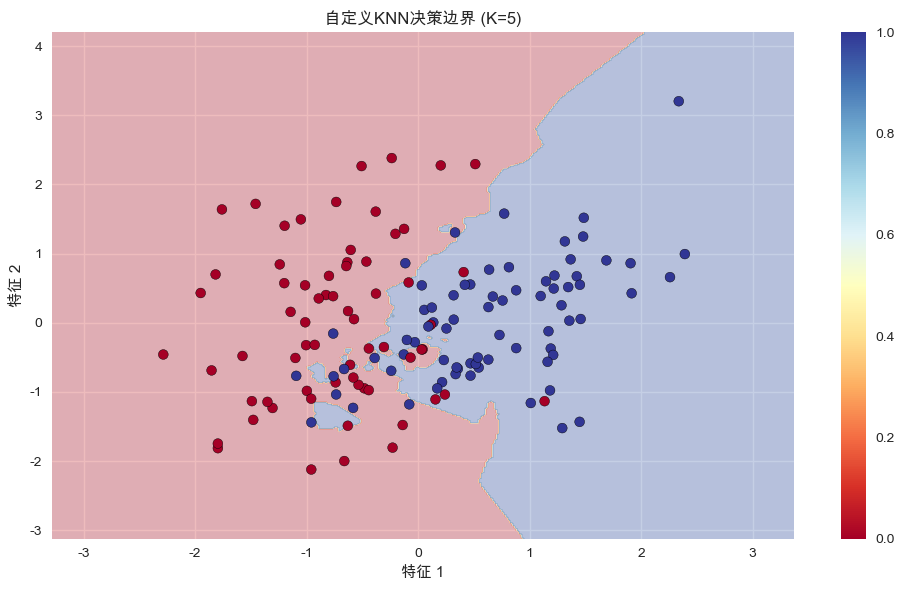

In [20]:
def plot_decision_boundary(model, X, y, title="KNN决策边界"):
    """绘制决策边界"""
    h = 0.02  # 网格步长
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', edgecolors='black', s=50)
    plt.xlabel('特征 1')
    plt.ylabel('特征 2')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# 可视化
plot_decision_boundary(knn, X_train_scaled, y_train, "自定义KNN决策边界 (K=5)")

## 3️⃣ 使用Scikit-learn的KNN

### 3.1 KNN分类器

In [21]:
# 加载鸢尾花数据集
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42
)

# 特征标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 创建KNN分类器
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_scaled, y_train)

# 预测
y_pred = knn_clf.predict(X_test_scaled)

# 评估
print("KNN分类器性能评估")
print("=" * 50)
print(f"准确率: {accuracy_score(y_test, y_pred):.4f}")
print("\n分类报告：")
print(classification_report(y_test, y_pred, target_names=iris.target_names))
print("\n混淆矩阵：")
print(confusion_matrix(y_test, y_pred))

KNN分类器性能评估
准确率: 1.0000

分类报告：
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45


混淆矩阵：
[[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


### 3.2 K值选择

K值的选择对模型性能影响很大：
- **K太小**：容易过拟合，对噪声敏感
- **K太大**：容易欠拟合，决策边界过于平滑

通常使用交叉验证选择最优K值

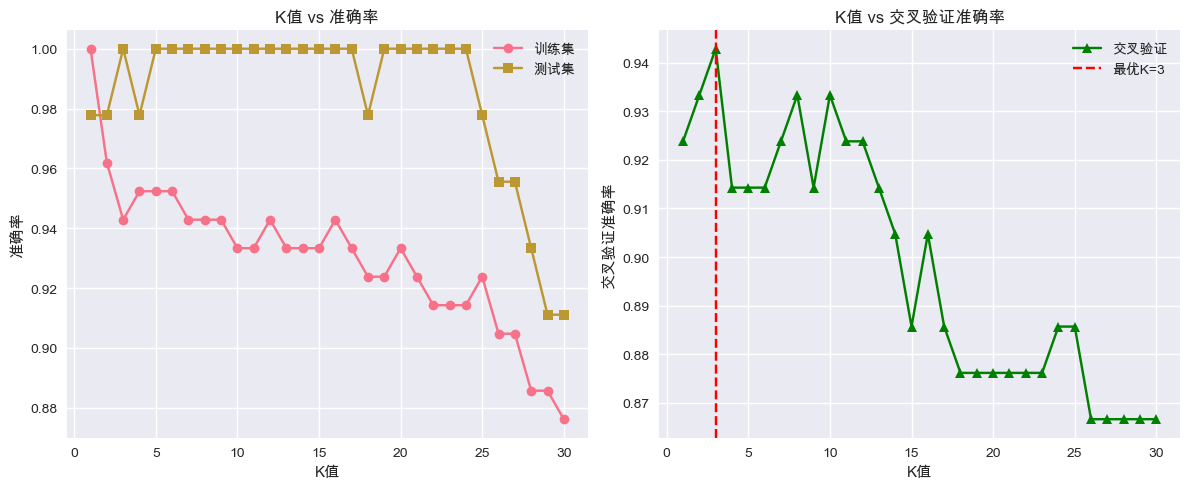

最优K值: 3
最高交叉验证准确率: 0.9429


In [22]:
# 测试不同的K值
k_range = range(1, 31)
train_scores = []
test_scores = []
cv_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    
    # 训练集准确率
    train_scores.append(knn.score(X_train_scaled, y_train))
    
    # 测试集准确率
    test_scores.append(knn.score(X_test_scaled, y_test))
    
    # 交叉验证准确率
    cv_score = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    cv_scores.append(cv_score.mean())

# 可视化
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, train_scores, label='训练集', marker='o')
plt.plot(k_range, test_scores, label='测试集', marker='s')
plt.xlabel('K值')
plt.ylabel('准确率')
plt.title('K值 vs 准确率')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range, cv_scores, label='交叉验证', marker='^', color='green')
plt.xlabel('K值')
plt.ylabel('交叉验证准确率')
plt.title('K值 vs 交叉验证准确率')
best_k = k_range[np.argmax(cv_scores)]
plt.axvline(best_k, color='red', linestyle='--', label=f'最优K={best_k}')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"最优K值: {best_k}")
print(f"最高交叉验证准确率: {max(cv_scores):.4f}")

### 3.3 不同距离度量的比较


不同距离度量的性能对比：
   距离度量   训练集准确率   测试集准确率  交叉验证准确率
   欧氏距离 0.952381 1.000000 0.914286
  曼哈顿距离 0.942857 1.000000 0.923810
 切比雪夫距离 0.942857 0.955556 0.933333
闵可夫斯基距离 0.952381 1.000000 0.914286


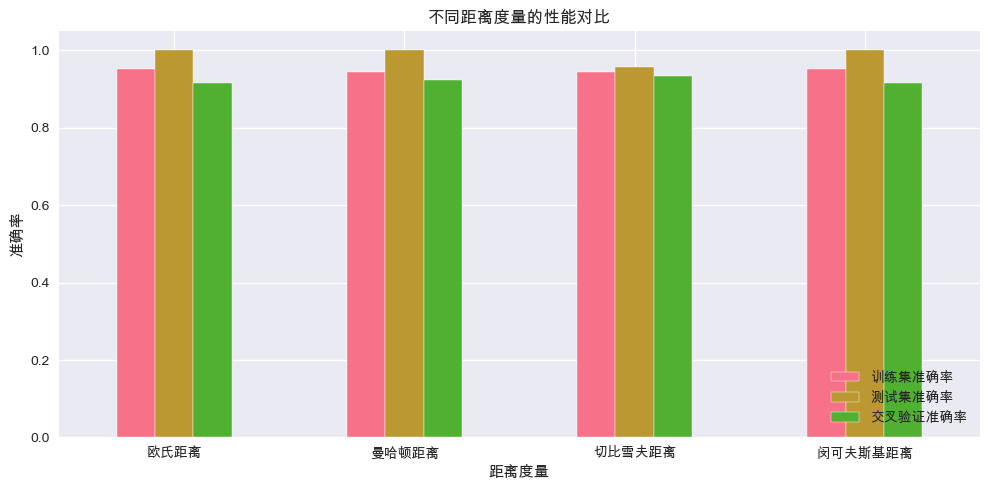

In [23]:
# 测试不同的距离度量
metrics = {
    'euclidean': '欧氏距离',
    'manhattan': '曼哈顿距离',
    'chebyshev': '切比雪夫距离',
    'minkowski': '闵可夫斯基距离'
}

results = []

for metric_name, metric_label in metrics.items():
    knn = KNeighborsClassifier(n_neighbors=5, metric=metric_name)
    knn.fit(X_train_scaled, y_train)
    
    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)
    cv_acc = cross_val_score(knn, X_train_scaled, y_train, cv=5).mean()
    
    results.append({
        '距离度量': metric_label,
        '训练集准确率': train_acc,
        '测试集准确率': test_acc,
        '交叉验证准确率': cv_acc
    })

# 显示结果
results_df = pd.DataFrame(results)
print("\n不同距离度量的性能对比：")
print(results_df.to_string(index=False))

# 可视化
results_df.set_index('距离度量')[['训练集准确率', '测试集准确率', '交叉验证准确率']].plot(
    kind='bar', figsize=(10, 5), rot=0
)
plt.ylabel('准确率')
plt.title('不同距离度量的性能对比')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### 3.4 KNN回归

KNN回归器性能评估
均方误差 (MSE): 340.60
R² 分数: 0.9601


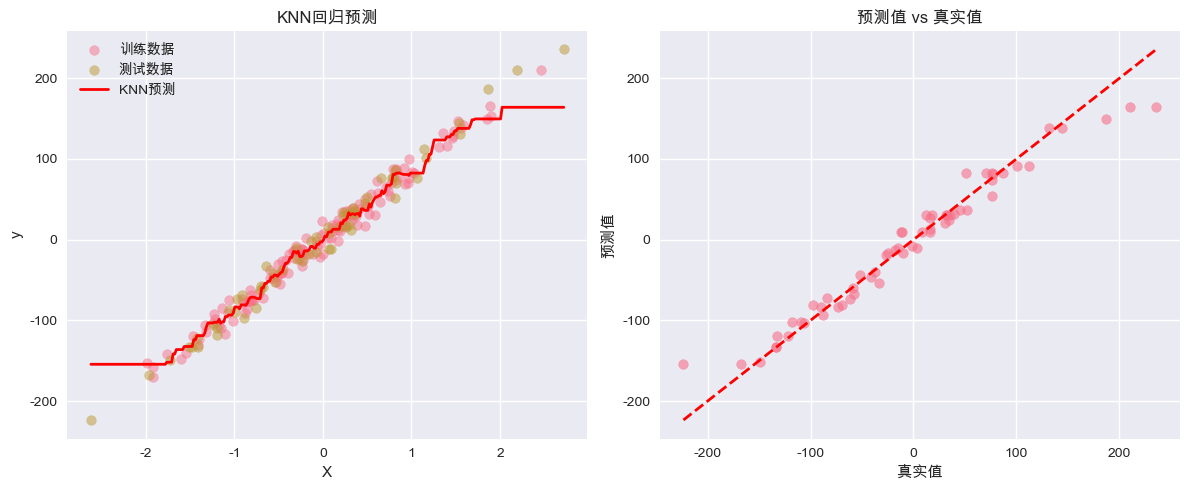

In [24]:
# 生成回归数据
X_reg, y_reg = make_regression(n_samples=200, n_features=1, noise=10, random_state=42)

# 划分数据集
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

# 训练KNN回归器
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_reg, y_train_reg)

# 预测
y_pred_reg = knn_reg.predict(X_test_reg)

# 评估
print("KNN回归器性能评估")
print("=" * 50)
print(f"均方误差 (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R² 分数: {r2_score(y_test_reg, y_pred_reg):.4f}")

# 可视化
plt.figure(figsize=(12, 5))

# 左图：数据点和预测线
plt.subplot(1, 2, 1)
X_plot = np.linspace(X_reg.min(), X_reg.max(), 300).reshape(-1, 1)
y_plot = knn_reg.predict(X_plot)

plt.scatter(X_train_reg, y_train_reg, alpha=0.5, label='训练数据')
plt.scatter(X_test_reg, y_test_reg, alpha=0.5, label='测试数据')
plt.plot(X_plot, y_plot, 'r-', linewidth=2, label='KNN预测')
plt.xlabel('X')
plt.ylabel('y')
plt.title('KNN回归预测')
plt.legend()
plt.grid(True)

# 右图：预测值 vs 真实值
plt.subplot(1, 2, 2)
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 
         'r--', lw=2)
plt.xlabel('真实值')
plt.ylabel('预测值')
plt.title('预测值 vs 真实值')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4️⃣ 参数调优

使用网格搜索找到最优参数组合

In [25]:
# 定义参数网格
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],  # 距离加权
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# 创建网格搜索
grid_search = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 训练
grid_search.fit(X_train_scaled, y_train)

# 最优参数
print("\n最优参数：")
print(grid_search.best_params_)
print(f"\n最优交叉验证准确率: {grid_search.best_score_:.4f}")

# 测试集评估
best_knn = grid_search.best_estimator_
test_score = best_knn.score(X_test_scaled, y_test)
print(f"测试集准确率: {test_score:.4f}")

# 查看前10个结果
results_df = pd.DataFrame(grid_search.cv_results_)
print("\n前10个最佳参数组合：")
print(results_df[['params', 'mean_test_score', 'rank_test_score']]
      .sort_values('rank_test_score')
      .head(10)
      .to_string(index=False))

Fitting 5 folds for each of 36 candidates, totalling 180 fits

最优参数：
{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}

最优交叉验证准确率: 0.9429
测试集准确率: 1.0000

前10个最佳参数组合：
                                                           params  mean_test_score  rank_test_score
  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}         0.942857                1
 {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}         0.942857                1
{'metric': 'minkowski', 'n_neighbors': 11, 'weights': 'distance'}         0.942857                1
 {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}         0.942857                1
 {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}         0.942857                1
 {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}         0.942857                1
  {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}         0.942857                1
{'metric': 'euclidea

## 5️⃣ 维度灾难 (Curse of Dimensionality)

### 理解维度灾难
随着特征维度增加：
1. 样本间距离趋于相等
2. "近邻"概念失效
3. 需要指数级增长的样本数量

让我们通过实验来验证


维度对KNN性能的影响：
 维度    训练准确率    测试准确率      平均距离    距离标准差     变异系数
  2 0.962857 0.953333  1.809504 0.917835 0.507230
  5 0.957143 0.900000  2.981424 1.033673 0.346704
 10 0.960000 0.873333  4.374507 1.115966 0.255107
 20 0.908571 0.793333  6.217599 1.035876 0.166604
 50 0.808571 0.733333  9.900544 1.021460 0.103172
100 0.800000 0.713333 14.132473 1.009730 0.071447


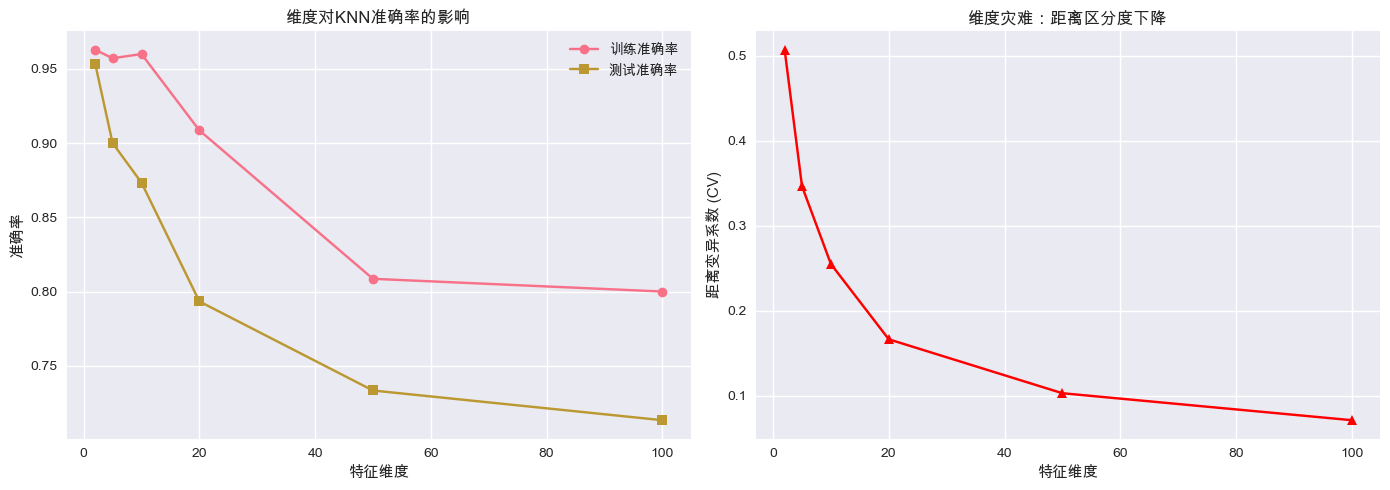


💡 观察：
1. 随着维度增加，测试准确率可能下降
2. 距离变异系数下降，说明样本间距离趋于相等
3. 这就是'维度灾难'现象


In [26]:
# 测试不同维度对KNN性能的影响
dimensions = [2, 5, 10, 20, 50, 100]
performance = []

for n_features in dimensions:
    # 生成数据
    X, y = make_classification(
        n_samples=500,
        n_features=n_features,
        n_informative=min(n_features, 10),
        n_redundant=0,
        random_state=42
    )
    
    # 划分数据
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # 标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 训练KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    
    # 评估
    train_acc = knn.score(X_train_scaled, y_train)
    test_acc = knn.score(X_test_scaled, y_test)
    
    # 计算平均距离（验证维度灾难）
    distances = []
    for i in range(min(100, len(X_train_scaled))):
        dists = np.sqrt(np.sum((X_train_scaled[i] - X_train_scaled) ** 2, axis=1))
        distances.extend(dists[dists > 0])  # 排除自身
    
    avg_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    performance.append({
        '维度': n_features,
        '训练准确率': train_acc,
        '测试准确率': test_acc,
        '平均距离': avg_distance,
        '距离标准差': std_distance,
        '变异系数': std_distance / avg_distance  # CV值，衡量距离的区分度
    })

# 结果分析
perf_df = pd.DataFrame(performance)
print("\n维度对KNN性能的影响：")
print(perf_df.to_string(index=False))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：准确率 vs 维度
axes[0].plot(perf_df['维度'], perf_df['训练准确率'], marker='o', label='训练准确率')
axes[0].plot(perf_df['维度'], perf_df['测试准确率'], marker='s', label='测试准确率')
axes[0].set_xlabel('特征维度')
axes[0].set_ylabel('准确率')
axes[0].set_title('维度对KNN准确率的影响')
axes[0].legend()
axes[0].grid(True)

# 右图：距离变异系数 vs 维度
axes[1].plot(perf_df['维度'], perf_df['变异系数'], marker='^', color='red')
axes[1].set_xlabel('特征维度')
axes[1].set_ylabel('距离变异系数 (CV)')
axes[1].set_title('维度灾难：距离区分度下降')
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n💡 观察：")
print("1. 随着维度增加，测试准确率可能下降")
print("2. 距离变异系数下降，说明样本间距离趋于相等")
print("3. 这就是'维度灾难'现象")

## 6️⃣ 特征缩放的重要性

KNN基于距离计算，因此对特征缩放非常敏感

特征统计信息：
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453         0.572359   
min    

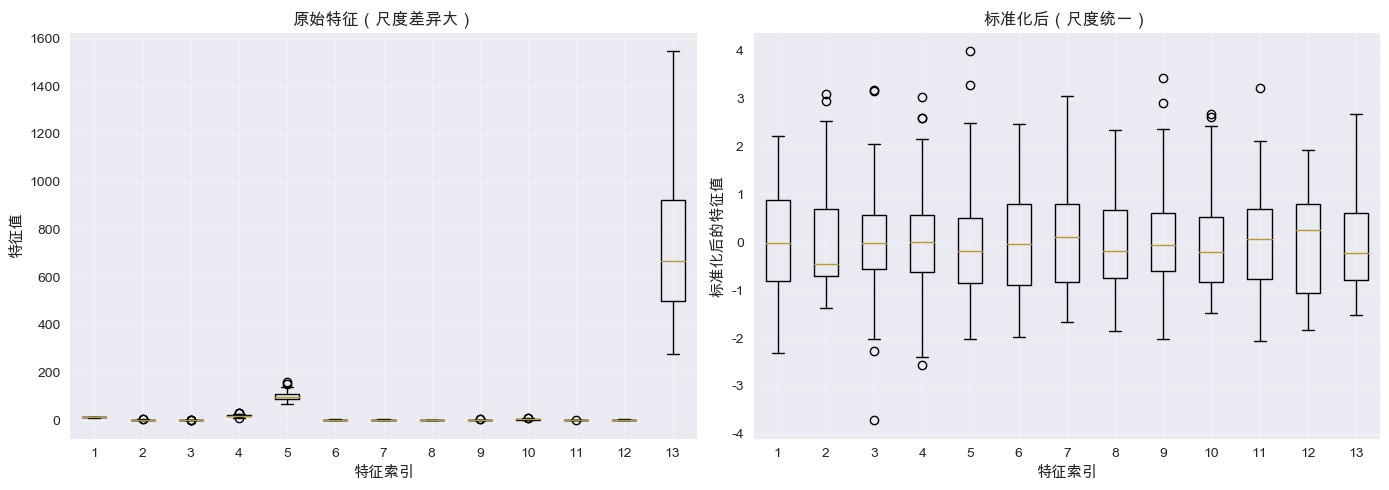

In [27]:
# 加载葡萄酒数据集（特征尺度差异大）
wine = load_wine()
X_wine = wine.data
y_wine = wine.target

# 查看特征的统计信息
print("特征统计信息：")
print(pd.DataFrame(X_wine, columns=wine.feature_names).describe())

# 划分数据
X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine, test_size=0.3, random_state=42
)

# 1. 不缩放
knn_no_scale = KNeighborsClassifier(n_neighbors=5)
knn_no_scale.fit(X_train, y_train)
score_no_scale = knn_no_scale.score(X_test, y_test)

# 2. 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)
score_scaled = knn_scaled.score(X_test_scaled, y_test)

# 对比
print("\n特征缩放的影响：")
print(f"不缩放准确率: {score_no_scale:.4f}")
print(f"标准化后准确率: {score_scaled:.4f}")
print(f"提升: {(score_scaled - score_no_scale) * 100:.2f}%")

# 可视化特征尺度
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始特征
axes[0].boxplot(X_train, labels=range(1, X_train.shape[1] + 1))
axes[0].set_xlabel('特征索引')
axes[0].set_ylabel('特征值')
axes[0].set_title('原始特征（尺度差异大）')
axes[0].grid(True, alpha=0.3)

# 标准化后
axes[1].boxplot(X_train_scaled, labels=range(1, X_train_scaled.shape[1] + 1))
axes[1].set_xlabel('特征索引')
axes[1].set_ylabel('标准化后的特征值')
axes[1].set_title('标准化后（尺度统一）')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7️⃣ KNN实用技巧

### 7.1 加权KNN
距离更近的邻居应该有更大的权重

权重策略对比：
Uniform权重准确率: 0.9630
Distance权重准确率: 0.9444


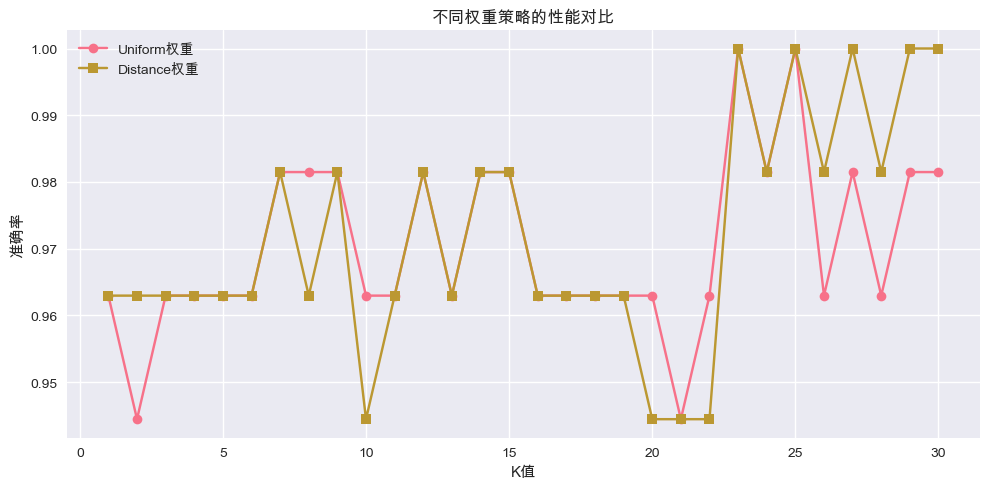

In [28]:
# 比较uniform vs distance权重
knn_uniform = KNeighborsClassifier(n_neighbors=10, weights='uniform')
knn_distance = KNeighborsClassifier(n_neighbors=10, weights='distance')

# 使用iris数据集
knn_uniform.fit(X_train_scaled, y_train)
knn_distance.fit(X_train_scaled, y_train)

score_uniform = knn_uniform.score(X_test_scaled, y_test)
score_distance = knn_distance.score(X_test_scaled, y_test)

print("权重策略对比：")
print(f"Uniform权重准确率: {score_uniform:.4f}")
print(f"Distance权重准确率: {score_distance:.4f}")

# 可视化不同K值下的性能
k_values = range(1, 31)
uniform_scores = []
distance_scores = []

for k in k_values:
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance')
    
    knn_u.fit(X_train_scaled, y_train)
    knn_d.fit(X_train_scaled, y_train)
    
    uniform_scores.append(knn_u.score(X_test_scaled, y_test))
    distance_scores.append(knn_d.score(X_test_scaled, y_test))

plt.figure(figsize=(10, 5))
plt.plot(k_values, uniform_scores, label='Uniform权重', marker='o')
plt.plot(k_values, distance_scores, label='Distance权重', marker='s')
plt.xlabel('K值')
plt.ylabel('准确率')
plt.title('不同权重策略的性能对比')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 📊 总结

### KNN的关键要点
1. **简单直观**：基于"物以类聚"的思想
2. **懒惰学习**：训练阶段只存储数据，预测时才计算
3. **参数选择**：
   - K值：通过交叉验证选择
   - 距离度量：欧氏距离通常是好的起点
   - 权重：distance权重通常优于uniform
4. **预处理**：特征标准化至关重要
5. **局限性**：
   - 预测速度慢（需要计算所有距离）
   - 维度灾难
   - 内存消耗大

### 使用建议
✅ **适合场景：**
- 小到中等规模数据集
- 低维特征空间
- 决策边界不规则的问题
- 作为baseline模型

❌ **不适合场景：**
- 大规模数据集（预测慢）
- 高维特征空间
- 实时预测场景
- 内存受限的环境

### 优化策略
1. 使用KD树或Ball树加速（Scikit-learn自动优化）
2. 降维（PCA）缓解维度灾难
3. 特征选择去除无关特征
4. 适当的特征缩放

---

## 💡 练习题

1. **基础练习**：使用make_moons数据集，找到最优K值
2. **进阶练习**：实现加权KNN（距离加权）
3. **挑战练习**：在手写数字识别(MNIST)数据集上应用KNN，对比不同降维方法的效果

下一节：[04_naive_bayes.ipynb](04_naive_bayes.ipynb) - 朴素贝叶斯